In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.4
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [12]:
layer = tf.keras.layers.Dense(100, input_shape=(None, 5))
layer(tf.zeros([10, 5]))

<tf.Tensor: shape=(10, 100), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.,

In [13]:
# layer.variables  #=> kernel + bias
# layer.trainable_variables
# help(layer)

In [14]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [15]:
from sklearn.model_selection import train_test_split

xtrain_all, xtest, ytrain_all, ytest = train_test_split(
    housing.data, housing.target, random_state=7)
xtrain, xvalid, ytrain, yvalid = train_test_split(
    xtrain_all ,ytrain_all, random_state=11)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xvalid_scaled= scaler.transform(xvalid)
xtest_scaled = scaler.transform(xtest)

In [24]:
# tf.nn.softplus: log(1+e^x)  平滑版的 relu
customized_softplus = keras.layers.Lambda(lambda x: tf.nn.softplus(x))
print(customized_softplus([-10., -5., 0., 5., 10.]))

tf.Tensor([4.5398898e-05 6.7153485e-03 6.9314718e-01 5.0067153e+00 1.0000046e+01], shape=(5,), dtype=float32)


In [25]:
def customized_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units  # number of nodes
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        """Construct parameters"""
        self.kernel = self.add_weight(
            name="kernel", 
            shape=(input_shape[1], self.units),
            initializer="uniform",
            trainable=True)  # 在训练过程中可变
        self.bias = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer="zeros",
            trainable=True)  # 在训练过程中可变
        super(CustomizedDenseLayer, self).build(input_shape)
    
    def call(self, x):
        """正向计算，从输入到输出"""
        return self.activation(x@self.kernel + self.bias)

model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu', input_shape=xtrain.shape[1:]),
    CustomizedDenseLayer(1),
    customized_softplus
    # keras.layers.Dense(1, activation="softplus")
    # keras.layers.Dense(1), keras.layers.Activation("softplus")
])
model.summary()
model.compile(loss=customized_mse, optimizer='sgd',
              metrics=["mean_squared_error"])
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-5)]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer_4 (Cu (None, 30)                270       
_________________________________________________________________
customized_dense_layer_5 (Cu (None, 1)                 31        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(xtrain_scaled, ytrain, 
                    validation_data=(xvalid_scaled, yvalid),
                    epochs=100, callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.0776 - mean_squared_error: 1.0776 - val_loss: 0.6375 - val_mean_squared_error: 0.6375
Epoch 2/100
363/363 [==============================] - 0s 990us/step - loss: 0.5500 - mean_squared_error: 0.5500 - val_loss: 0.5484 - val_mean_squared_error: 0.5484
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4876 - mean_squared_error: 0.4876 - val_loss: 0.4916 - val_mean_squared_error: 0.4916
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4601 - mean_squared_error: 0.4601 - val_loss: 0.4711 - val_mean_squared_error: 0.4711
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4535 - mean_squared_error: 0.4535 - val_loss: 0.4765 - val_mean_squared_error: 0.4765
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4377 - mean_squared_error: 0.4377 - val_loss: 0.4506 - val_mean_squared_error: 0.4506
Epoch 7/100
363/363 

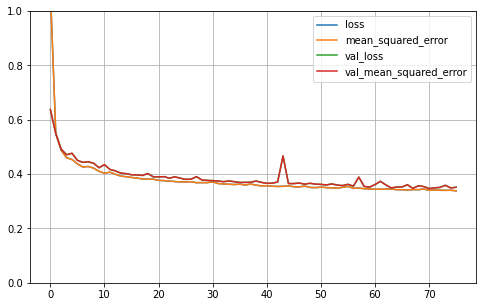

In [22]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [23]:
model.evaluate(xtest_scaled, ytest, verbose=0)

[0.3581102192401886, 0.3581102192401886]